In [147]:
NOTEBOOK_NAME = 'model.ipynb'

In [1]:
import os
import tqdm
import matplotlib.pyplot as plt

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch import nn
import torchvision as tv

from torchvision.models import efficientnet, EfficientNet_V2_M_Weights
from torchvision import datasets, transforms

from utils import save_pickle, load_pickle, ImageSearcher

In [14]:
EXP_NAME = 'efficientnet'
ARTIFCAT_PATH = os.path.join(EXP_NAME, 'artifacts')
os.makedirs(ARTIFCAT_PATH, exist_ok=True)

In [2]:
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
device

'cuda:1'

In [3]:
searcher = ImageSearcher('train')

## Dataset

In [4]:
class ImageLoader(torch.utils.data.Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        files = os.listdir(self.folder)
        self.labels = ['.'.join(e.split('.')[:-1]) for e in files]
        self.files = [os.path.join(folder, f) for f in files]
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        image_path = self.files[idx]
        image = tv.io.read_image(image_path)
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.labels[idx]
        
        return (image, label)

In [21]:
IMAGE_SIZE = 480


ds_train = ImageLoader(
    folder='torch_data/train',
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ConvertImageDtype(torch.float32),
    ])
)

ds_val = ImageLoader(
    folder='torch_data/val',
    transform=transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ConvertImageDtype(torch.float32),
    ])
)

In [30]:
train_loader = torch.utils.data.DataLoader(
    ds_train,
    64,
)

val_loader = torch.utils.data.DataLoader(
    ds_val,
    64,
)

## Model

In [7]:
model = efficientnet.efficientnet_v2_m(EfficientNet_V2_M_Weights.IMAGENET1K_V1)
model.classifier[1] = nn.Identity()

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [8]:
model = model.to(device)

## Embeddings

In [23]:
def collect_preds(module, loader):
    x_all = []
    y_all = []
    for x, y in tqdm.tqdm(loader):
        with torch.no_grad():
            x = model(x.to(device)).cpu().numpy()
            x_all.append(x)
            y_all.append(y)
            
    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    
    return x_all, y_all

### computing embeddings

In [24]:
x_train, y_train = collect_preds(model, train_loader)
x_val, y_val = collect_preds(model, val_loader)

100%|██████████| 109/109 [05:19<00:00,  2.93s/it]


In [34]:
save_pickle([x_train, y_train], os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_train.pkl'))
save_pickle([x_val, y_val], os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_val.pkl'))

# Model

In [150]:
import pandas as pd
from utils import load_pickle
from sklearn.metrics import mean_squared_error
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

from tqdm.notebook import tqdm
import shutil

In [49]:
def prepare_data(x, y, meta_all):
    y = meta_all.set_index('Id').loc[y]['Pawpularity'].to_numpy()
    y = y / 100
    
    x = x.astype(np.float32)
    y = y.astype(np.float32)

    return x, y

In [ ]:
meta_all = pd.read_csv('train.csv')

In [399]:
x_train, y_train = load_pickle(os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_train.pkl'))
x_val, y_val = load_pickle(os.path.join(ARTIFCAT_PATH, 'efficientnet_v2_val.pkl'))

x_train, y_train = prepare_data(x_train, y_train, meta_all)
x_val, y_val = prepare_data(x_val, y_val, meta_all)

In [400]:
EMB_SIZE = x_train.shape[1]

In [401]:
rmse = lambda yh, y: mean_squared_error(y, yh) ** 0.5

In [402]:
def l1_reg(module: nn.Module):
    flat_weights = torch.cat([e.view(-1) for e in module.parameters()])
    flat_weights = torch.abs(flat_weights)
    loss = torch.sum(flat_weights)
    
    return loss

In [403]:
class PawpularityEmbeddingsDataset(data.Dataset):
    def __init__(self, x, y):
        super().__init__()
        
        self.x = x
        self.y = y[:, np.newaxis]
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [458]:
class EmbEncoder(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        l1_dims = in_dim // 2
        l2_dims = in_dim // 4
        
        self.l1 = nn.Linear(in_dim, l1_dims)
        self.l1_act = nn.GELU()
        self.l2 = nn.Linear(l1_dims, l2_dims)
        self.l2_act = nn.GELU()
        self.l3 = nn.Linear(l2_dims, out_dim)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l1_act(x)
        x = self.l2(x)
        x = self.l2_act(x)
        x = self.l3(x)
        
        return x
    
class EmbDecoder(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        l1_dims = in_dim * 2
        l2_dims = in_dim * 4
        
        self.l1 = nn.Linear(in_dim, l1_dims)
        self.l1_act = nn.GELU()
        self.l2 = nn.Linear(l1_dims, l2_dims)
        self.l2_act = nn.GELU()
        self.l3 = nn.Linear(l2_dims, out_dim)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.l1_act(x)
        x = self.l2(x)
        x = self.l2_act(x)
        x = self.l3(x)
        
        return x

In [494]:
class PawpularityHead(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        enc_dim = 32
        self.enc = EmbEncoder(in_dim, enc_dim)
        self.dec = EmbDecoder(enc_dim, in_dim)
        self.fc = nn.Linear(enc_dim, 1)
        self.fc_act = nn.Sigmoid() # for test simplicity
        
    def forward(self, x):
        x = self.enc(x)
        if self.training:
            xh = self.dec(x)
        x = self.fc(x)
        x = self.fc_act(x)
        
        if self.training:
            return x, xh
        
        return x

In [495]:
def test(module, test_dl, metrics:dict):
    module = module.train(False)
    
    yh = []
    yt = []
    with torch.no_grad():
        for x, y in test_dl:
            yhc = module(x).detach().cpu().numpy()
            yh.append(yhc)
            yt.append(y)
            
    yh = np.concatenate(yh, axis=0)
    y = np.concatenate(yt, axis=0)
    
    res = {}
    for mname, mfunc in metrics.items():
        res[mname] = mfunc(yh, y)
    
    return res

In [496]:
def train(
    module: nn.Module, 
    loss_f, 
    optimizer: torch.optim.Optimizer, 
    train_dl: data.DataLoader, 
    test_dl: data.DataLoader, 
    epochs: int,
    loss_alpha=0.01,
    pbar_update_steps: int=100,
    ):
    
    logs = []
    test_logs = []
    for epoch in range(epochs):
        module = module.train(True)
        with tqdm(total=len(train_dl)) as pbar:
            pbar.set_description(f'epoch {epoch}')
            
            for step, (x, y) in enumerate(train_dl):
                yh, xh = module(x)
                loss = loss_f(yh, y)
                rec_loss = torch.linalg.norm(x - xh, dim=1).mean()
                
                loss_full = loss + loss_alpha * rec_loss
    
                optimizer.zero_grad()
                loss_full.backward()
                optimizer.step()
                
                loss = loss.detach().cpu().numpy()
                rec_loss = rec_loss.detach().cpu().numpy()
                
                log = {
                    'loss' : float(loss), 
                    'rec_loss': float(rec_loss),
                    'rmse': rmse(yh.detach().cpu().numpy(), y.detach().cpu().numpy()),
                }
                logs.append(log)
                
                if step % pbar_update_steps == 0:
                    running_loss = {
                        key: np.mean([log[key] for log in logs[-pbar_update_steps:]])
                        for key in log
                    }
                    pbar.set_postfix({'loss' : running_loss})

                pbar.update()
        
        test_metrics = test(module, test_dl, {'rmse' : rmse})
        test_logs.append(test_metrics)
        print(test_metrics)
    
    return logs, test_logs

In [514]:
def split_by_regularization(module: nn.Module, reg_list:list):
    """
    Returns:
        (common_params, reg_params)
    """
    reg_list = set(reg_list)
    reg_params = []
    common_params = []
    
    for name, p in model.named_parameters():
        if name in reg_list:
            reg_params.append(p)
        else:
            common_params.append(p)
    
    return common_params, reg_params

In [497]:
METRIC_COLLECTION_STEPS = 100
SUB_EXP_NAME = 'dim_reduction'
SUB_EXP_ARTIFACTS = os.path.join(ARTIFCAT_PATH, SUB_EXP_NAME)
os.makedirs(SUB_EXP_ARTIFACTS, exist_ok=True)

In [518]:
model = PawpularityHead(EMB_SIZE)
embs_dataset_train = PawpularityEmbeddingsDataset(x_train, y_train)
embs_dataset_val = PawpularityEmbeddingsDataset(x_val, y_val)

loader_train = data.DataLoader(embs_dataset_train, 64)
loader_val = data.DataLoader(embs_dataset_val, 64)

loss_fn = nn.BCELoss()
clean_params, reg_params = split_by_regularization(model, ['fc.weight', 'enc.l3.weight'])
print('reg_params: ', len(reg_params))
optimizer = torch.optim.Adam([
        {'params' : clean_params},
        {'params' : reg_params, 'weight_decay' : 0.01},
    ],
    lr=1e-3)
logs, test_logs = train(
    model, 
    loss_fn, 
    optimizer, 
    loader_train, 
    loader_val, 
    epochs=10, 
    loss_alpha=1,
    pbar_update_steps=METRIC_COLLECTION_STEPS)

reg_params:  2


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.1871546405838325}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.1853385458456638}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.1883848688695774}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.19561218158784496}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20671995619625957}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.21123101864415592}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.22705916522554287}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.21488217963794853}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20396837881097438}


  0%|          | 0/109 [00:00<?, ?it/s]

{'rmse': 0.20874162640023788}


In [ ]:
save_pickle(logs, os.path.join(SUB_EXP_ARTIFACTS, 'train_logs.pkl'))
save_pickle(test_logs, os.path.join(SUB_EXP_ARTIFACTS, 'test_logs.pkl'))
save_pickle(model.state_dict(), os.path.join(SUB_EXP_ARTIFACTS, 'state_dict.pkl'))

In [ ]:
round(test_logs[-1]['rmse'], 4)

In [444]:
train_logs_df = pd.DataFrame(logs)

test_logs_df = pd.DataFrame(test_logs)
test_logs_df.index = test_logs_df.index * METRIC_COLLECTION_STEPS + METRIC_COLLECTION_STEPS

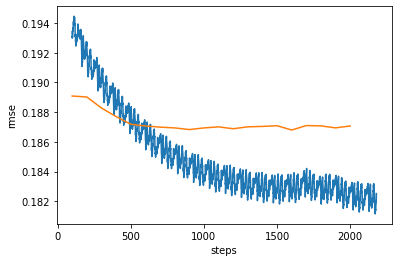

In [445]:
plt.xlabel('steps')
plt.ylabel('rmse')
train_logs_df['rmse'].rolling(METRIC_COLLECTION_STEPS).mean().plot()
test_logs_df['rmse'].plot()
plt.savefig(os.path.join(SUB_EXP_ARTIFACTS, 'rmse_plot.png'))

In [446]:
np.sum(np.abs(model.fc.weight.detach().cpu().numpy()[0]) < 1e-5)

25

(array([14., 13.,  5., 10.,  9., 35.,  3.,  9., 12., 18.]),
 array([-0.10420716, -0.08344065, -0.06267415, -0.04190765, -0.02114114,
        -0.00037464,  0.02039187,  0.04115837,  0.06192487,  0.08269138,
         0.10345788], dtype=float32),
 <BarContainer object of 10 artists>)

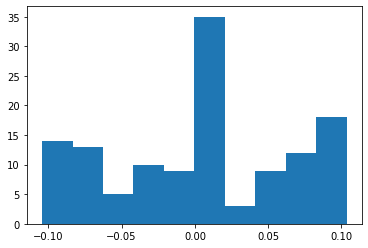

In [447]:
plt.hist(model.fc.weight.detach().cpu().numpy()[0])

In [398]:
shutil.copyfile(NOTEBOOK_NAME, os.path.join(SUB_EXP_ARTIFACTS, 'model.ipynb'))

'efficientnet/artifacts/dim_reduction_pca/model.ipynb'